In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import math
import pickle
import random
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 訓練データ
train_df = pd.read_parquet("./train.parquet")
print(train_df.sample(frac=1).head(30))

         kind      date  amount  mode_price       area  year  weekno
36629     トマト  20060123  112313      1260.0   各地_愛知_熊本  2006       4
7946     にんじん  20230424  170014      1944.0   各地_徳島_静岡  2023      17
17896    はくさい  20121218  206070       840.0         茨城  2012      51
65824    そらまめ  20160613   11216      2700.0   各地_宮城_茨城  2016      24
18499    はくさい  20150326  156016      1296.0      各地_茨城  2015      13
66132    そらまめ  20210527   12522      2106.0      千葉_茨城  2021      21
31520    きゅうり  20190112   91711      2160.0   千葉_各地_宮崎  2019       2
65823    そらまめ  20160611   12220      1728.0   各地_宮城_茨城  2016      23
40689     トマト  20210419  187345      1080.0   各地_栃木_熊本  2021      16
24469    こまつな  20200323   24677       135.0      各地_埼玉  2020      13
25752   しゅんぎく  20110224    5532        53.0   千葉_各地_栃木  2011       8
60055  なましいたけ  20201116   23396       108.0   各地_岩手_栃木  2020      47
51980   さつまいも  20111222   75799      1470.0      千葉_各地  2011      51
26058   しゅんぎく  20181109    8540   

In [ ]:
# テストデータ
test_df = pd.read_parquet("./test.parquet")
print(test_df.sample(frac=1).head(30))

       kind      date         area  year  weekno
14     にんじん  20230721    北海道_各地_青森  2023      29
24     キャベツ  20230704     各地_岩手_群馬  2023      27
123    きゅうり  20230720     各地_岩手_福島  2023      29
178    ピーマン  20230704     各地_岩手_茨城  2023      27
71     こまつな  20230708        各地_東京  2023      27
59     はくさい  20230722           長野  2023      29
8      にんじん  20230713    北海道_各地_青森  2023      28
125    きゅうり  20230722     各地_岩手_福島  2023      29
118    きゅうり  20230713     各地_岩手_福島  2023      28
184    ピーマン  20230713     各地_岩手_茨城  2023      28
5      にんじん  20230708    北海道_各地_青森  2023      27
138    かぼちゃ  20230710  メキシコ_各地_神奈川  2023      28
161     トマト  20230711    北海道_各地_青森  2023      28
151    かぼちゃ  20230728  メキシコ_各地_神奈川  2023      30
34     キャベツ  20230719     各地_岩手_群馬  2023      29
10     にんじん  20230715    北海道_各地_青森  2023      28
124    きゅうり  20230721     各地_岩手_福島  2023      29
189    ピーマン  20230720     各地_岩手_茨城  2023      29
21     にんじん  20230731    北海道_各地_青森  2023      31
77     こまつな  2023071

In [6]:
# Positional Encodingを行うためのクラス関数
class MyPositionalEncoding(nn.Module):
    def __init__(self, hidden_n, max_time_series, dropout_rate=0.1):
        super().__init__()
        self.hidden_n = hidden_n  # 埋め込み次元数(64×8=512などのMultiheadSelfAttention層のパーセプトロン数)
        self.dropout = nn.Dropout(dropout_rate)

        position_encode = torch.zeros(max_time_series, self.hidden_n)  # (最大時系列数, 埋め込み次元数)のゼロ行列を作成

        position = torch.arange(0, max_time_series, dtype=torch.float)  # [0, 1, 2, ...]の最大時系列数のベクトルを作成
        position = position.unsqueeze(dim=1)  # 作成したベクトルを(最大時系列数, 1)の行列に変換

        calcu_terms = torch.arange(0, self.hidden_n, 2, dtype=torch.float)  # [0, 2, 4, ...]の埋め込み次元数÷2のベクトルを作成
        calcu_terms = torch.exp(calcu_terms * (-math.log(10000.0) / self.hidden_n))  # ベクトルの各値に対して所定の計算

        position_encode_even_columns = torch.sin(position * calcu_terms)  # 掛け算のブロードキャストで(最大時系列数, 埋め込み次元数÷2)の行列になる
        position_encode[:, 0::2] = position_encode_even_columns  # position_encode行列の全ての行の偶数列に代入

        position_encode_odd_columns = torch.cos(position * calcu_terms)  # 掛け算のブロードキャストで(最大時系列数, 埋め込み次元数÷2)の行列になる
        position_encode[:, 1::2] = position_encode_odd_columns  # position_encode行列の全ての行の奇数列に代入

        position_encode = position_encode.unsqueeze(dim=0)  # position_encode行列を(1, 最大時系列数, 埋め込み次元数)のテンソルに変換

        self.register_buffer("pe", position_encode)

    def forward(self, input):
        input = input * math.sqrt(self.hidden_n)  # PositionalEncoding層の入力データの各値に対して、埋め込み次元数の平方根を掛ける
        input_time_series = input.shape[1]  # PositionalEncoding層の入力データの時系列数を把握
        input = input + self.pe[:, :input_time_series, :]  # PositionalEncoding層の入力データに、時系列数の分のposition_encodeを加算
        return self.dropout(input)

In [7]:
# Transformerモデルを作るためのクラス関数
class MyTransformer(nn.Module):
    def __init__(self, enc_in_n, dec_in_n, hidden_n, out_n, enc_time_series, dec_time_series,
                 head_n=8, feedforward_hidden_n=1024, dropout_rate=0.2, transformer_layer_n=2):
        super().__init__()
        # Encoder側
        self.layer_1_encoder = nn.Linear(enc_in_n, hidden_n)
        self.layer_2_encoder = MyPositionalEncoding(hidden_n=hidden_n,  # 埋め込み次元数
                                                    max_time_series=enc_time_series)  # Encoder側の入力データの時系列数
        # Encoder側のTransformer層を定義
        transformer_layer_encoder = nn.TransformerEncoderLayer(d_model=hidden_n,  # 埋め込み次元数(例えば64×8=512)
                                                               nhead=head_n,  # Multihead数(例えば8)
                                                               dim_feedforward=feedforward_hidden_n,
                                                               dropout=dropout_rate,
                                                               activation="gelu",
                                                               layer_norm_eps=1e-5,
                                                               batch_first=True,
                                                               norm_first=False)
        # Encoder側のLayerNormalization層を定義
        layer_normalization_encoder = nn.LayerNorm(hidden_n)
        self.layer_3_encoder = nn.TransformerEncoder(encoder_layer=transformer_layer_encoder,  # 上記で定義したEncoder側のTransformer層
                                                     num_layers=transformer_layer_n,  # Transformer層を繋げる数
                                                     norm=layer_normalization_encoder,  # 上記で定義したEncoder側のLayerNormalization層
                                                     enable_nested_tensor=True,
                                                     mask_check=True)
        # Decoder側
        self.layer_1_decoder = nn.Linear(dec_in_n, hidden_n)
        self.layer_2_decoder = MyPositionalEncoding(hidden_n=hidden_n,  # 埋め込み次元数
                                                    max_time_series=dec_time_series)  # Decoder側の入力データの時系列数
        # 下記で定義するmy_mask関数でマスクを作成
        self.mask_matrix_decoder = self.my_mask(input_time_series=dec_time_series).to(DEVICE)
        # Decoder側のTransformer層を定義
        transformer_layer_decoder = nn.TransformerDecoderLayer(d_model=hidden_n,  # 埋め込み次元数(例えば64×8=512)
                                                               nhead=head_n,  # Multihead数(例えば8)
                                                               dim_feedforward=feedforward_hidden_n,
                                                               dropout=dropout_rate,
                                                               activation="gelu",
                                                               layer_norm_eps=1e-5,
                                                               batch_first=True,
                                                               norm_first=False)
        # Decoder側のLayerNormalization層を定義
        layer_normalization_decoder = nn.LayerNorm(hidden_n)
        self.layer_3_decoder = nn.TransformerDecoder(decoder_layer=transformer_layer_decoder,  # 上記で定義したDecoder側のTransformer層
                                                     num_layers=transformer_layer_n,  # Transformer層を繋げる数
                                                     norm=layer_normalization_decoder)  # 上記で定義したDecoder側のLayerNormalization層
        self.layer_4_decoder = nn.Linear(hidden_n, out_n)

    def forward(self, input_encoder, input_decoder):
        out_layer_1_encoder = self.layer_1_encoder(input_encoder)  # Encoder側の入力データ
        out_layer_2_encoder = self.layer_2_encoder(input=out_layer_1_encoder)
        out_layer_3_encoder = self.layer_3_encoder(src=out_layer_2_encoder,
                                                   mask=None,
                                                   is_causal=None,
                                                   src_key_padding_mask=None)
        out_layer_1_decoder = self.layer_1_decoder(input_decoder)  # Decoder側の入力データ
        out_layer_2_decoder = self.layer_2_decoder(input=out_layer_1_decoder)
        out_layer_3_decoder = self.layer_3_decoder(tgt=out_layer_2_decoder,  # Decoder側からのデータ
                                                   memory=out_layer_3_encoder,  # Encoder側からのデータ
                                                   tgt_mask=self.mask_matrix_decoder,  # Decoder側からのデータにかけるマスク
                                                   memory_mask=None,
                                                   tgt_key_padding_mask=None,
                                                   memory_key_padding_mask=None)
        output_decoder = self.layer_4_decoder(out_layer_3_decoder)
        return output_decoder

    # マスク(Decoder側Transformerのtgt_mask引数に設定する行列)を作るための関数
    def my_mask(self, input_time_series):
        mask_matrix = torch.triu(input=torch.full(size=(input_time_series, input_time_series),
                                                  fill_value=float("-inf")),
                                 diagonal=1)  # input_time_seriesの正方行列で値が-∞をfullで作り、triuで正方行列の対角線の上三角部分の値を0にする
        return mask_matrix

    # 推論で使う関数
    def predict_data(self, enc_input_data, dec_input_data, id2value_dict, feature_scaler):
        out_layer_1_encoder = self.layer_1_encoder(enc_input_data)
        out_layer_2_encoder = self.layer_2_encoder(input=out_layer_1_encoder)
        out_layer_3_encoder = self.layer_3_encoder(src=out_layer_2_encoder,
                                                   mask=None,
                                                   is_causal=None,
                                                   src_key_padding_mask=None)
        out_layer_1_decoder = self.layer_1_decoder(dec_input_data)
        out_layer_2_decoder = self.layer_2_decoder(input=out_layer_1_decoder)
        out_layer_3_decoder = self.layer_3_decoder(tgt=out_layer_2_decoder,
                                                   memory=out_layer_3_encoder,
                                                   tgt_mask=None,  # 推論時はDecoder側の入力データにマスクは不要
                                                   memory_mask=None,
                                                   tgt_key_padding_mask=None,
                                                   memory_key_padding_mask=None)
        output_decoder_first = self.layer_4_decoder(out_layer_3_decoder)
        # print(output_decoder_first.shape)  # (ミニバッチ数, 1, mode_priceを分類タスクとしたパーセプトロン数)  # Decoder側の入力データの時系列の1つ目のデータを入力しているため
        output_predict_id_first = torch.argmax(input=F.softmax(output_decoder_first[0],  # F.softmaxへの入力は行列のため、[0]でミニバッチ数の所だけ次元を落とす
                                                               dim=1),
                                               dim=1).to("cpu")  # 分類タスクとしているので、softmaxの結果にdim=1でargmaxを行って、確率値が最大の要素値を取得する
        # print(output_predict_id_first.shape)  # (1, )  # Decoder側の入力データの時系列の1つ目のデータを入力した結果のargmaxのため
        output_predict_value_array_first = np.array(id2value_dict[output_predict_id_first.item()])  # mode_price_idをmode_priceに変換する
        output_predict_value_matrix_first = output_predict_value_array_first.reshape(-1, 1)  # ベクトルになっているので行列にする(標準化するため)
        scaled_output_predict_value_matrix_first = feature_scaler.transform(output_predict_value_matrix_first)  # mode_priceを標準化する
        output_predict_value = torch.FloatTensor(scaled_output_predict_value_matrix_first).unsqueeze(dim=0).to(DEVICE)  # 行列を3階数テンソルにする(モデルに入力するため)
        for i in range(21):  # 逐次的な推論を21回繰り返す事で、21回目には22個(1+21)の時系列データを得る、
            valid_decoder_data_tensor_onebatch = torch.cat(tensors=[dec_input_data, output_predict_value],
                                                           dim=1)
            out_layer_1_decoder = self.layer_1_decoder(valid_decoder_data_tensor_onebatch)
            out_layer_2_decoder = self.layer_2_decoder(out_layer_1_decoder)
            out_layer_3_decoder = self.layer_3_decoder(tgt=out_layer_2_decoder,
                                                       memory=out_layer_3_encoder,
                                                       tgt_mask=None,
                                                       memory_mask=None,
                                                       tgt_key_padding_mask=None,
                                                       memory_key_padding_mask=None)
            output_decoder = self.layer_4_decoder(out_layer_3_decoder)
            output_predict_id = torch.argmax(input=F.softmax(output_decoder[0],
                                                             dim=1),
                                             dim=1).to("cpu")
            output_predict_value_array = np.array([id2value_dict[id] for id in np.array(output_predict_id)])  # mode_price_idをmode_priceに変換する
            output_predict_value_matrix = output_predict_value_array.reshape(-1, 1)  # ベクトルになっているので行列にする(標準化するため)
            scaled_output_predict_value_matrix = feature_scaler.transform(output_predict_value_matrix)  # mode_priceを標準化する
            output_predict_value = torch.FloatTensor(scaled_output_predict_value_matrix).unsqueeze(dim=0).to(DEVICE)  # 行列を3階数テンソルにする(モデルに再度入力するため)
        return output_predict_value_array  # 戻り値で戻すのは変数output_predict_value_array

In [8]:
# datasetを作るためのクラス関数
class MyDataset(Dataset):
    def __init__(self, chunk, array, time_series):
        encoder_index_from = 0
        encoder_index_to = chunk * time_series  # Encoder側の入力データの1時系列数はchunk×time_series
        decoder_explain_index_from = encoder_index_to - 1  # Decoder側の入力データの冒頭の値は、Encoderの入力データの末尾の値にする(Seq2Seqの考え方)
        decoder_explain_index_to = decoder_explain_index_from + chunk  # Decoder側の入力データの1時系列数はchunk
        decoder_target_index_from = encoder_index_to  # Decoder側の正解データは、Decoderの入力データの1つ先のデータになる
        decoder_target_index_to = decoder_target_index_from + chunk  # Decoder側の正解データも1時系列数はchunk
        self.encoder_explain_list = []
        self.decoder_explain_list = []
        self.decoder_target_list = []
        while True:
            if decoder_target_index_to <= len(array):
                self.encoder_explain_list.append(array[encoder_index_from:encoder_index_to, :-1].copy())  # Encoder側の入力データの特徴量はmode_priceとamount
                self.decoder_explain_list.append(array[decoder_explain_index_from:decoder_explain_index_to, 0].copy())  # Decoder側の入力データの特徴量はmode_price
                self.decoder_target_list.append(array[decoder_target_index_from:decoder_target_index_to, -1].copy())  # Decoder側の正解データの特徴量はmode_price_id
                encoder_index_from += chunk
                encoder_index_to += chunk
                decoder_explain_index_from += chunk
                decoder_explain_index_to += chunk
                decoder_target_index_from += chunk
                decoder_target_index_to += chunk
            else:
                break

    def __len__(self):
        return len(self.encoder_explain_list)

    def __getitem__(self, idx):  # DataLoaderから呼び出されると、idxが1ずつカウントアップして要素を取得する
        encoder_explain_tensor = torch.FloatTensor(self.encoder_explain_list[idx])
        decoder_explain_tensor = torch.FloatTensor(self.decoder_explain_list[idx])
        decoder_explain_tensor = decoder_explain_tensor.unsqueeze(dim=1)  # Decoderの入力データの特徴量はmode_priceのみで1次元になってしまうので、2次元にする
        decoder_target_tensor = torch.LongTensor(self.decoder_target_list[idx])
        decoder_target_tensor = decoder_target_tensor.unsqueeze(dim=1)  # Decoderの正解データの特徴量はmode_price_idのみで1次元になってしまうので、2次元にする
        return encoder_explain_tensor, decoder_explain_tensor, decoder_target_tensor

In [ ]:
# データを各特徴量毎にスケーリング(正規化)するための関数
def scaling_per_feature(data_matrix):
    scaling_column_num = data_matrix.shape[1] - 1  # データの特徴量の数は、行列の列の数だけれど、mode_price_idは正規化しないので-1する
    feature_scaler_dict = {}  # 各特徴量毎の正規化scalerインスタンスを格納する辞書変数
    for i in range(scaling_column_num):
        feature_scaler = preprocessing.MinMaxScaler()  # 正規化scalerインスタンスを作成
        feature_data_vector = data_matrix[:, i]  # データの1特徴量(1列)を取得
        feature_data_matrix = feature_data_vector.reshape(-1, 1)  # scalerを使うために1次元ベクトルを2次元行列へ変換
        feature_scaler.fit(feature_data_matrix)  # 正規化scalerインスタンスを特徴量に合わせる
        scaled_feature_data_matrix = feature_scaler.transform(feature_data_matrix)  # 特徴量を正規化
        scaled_feature_data_vector = scaled_feature_data_matrix.reshape(-1)  # 2次元行列を1次元ベクトルへ戻す
        if i == 0:
            # 1つ目の特徴量(0列目)(mode_price)の場合、1次元ベクトルをそのまま
            scaled_feature_data = scaled_feature_data_vector
        elif i == 1:
            # 2つ目の特徴量(1列目)(amount)の場合、1次元ベクトルの列方向に、1次元ベクトルをstackする
            scaled_feature_data = np.stack([scaled_feature_data, scaled_feature_data_vector],
                                           axis=1)
        else:
            # 3つ目以降の特徴量の場合、行列の列方向に、1次元ベクトルを2次元にしてconcatenateする
            scaled_feature_data = np.concatenate((scaled_feature_data, scaled_feature_data_vector.reshape(-1, 1)),
                                                 axis=1)
        # 辞書変数に正規化scalerインスタンスを格納
        feature_scaler_dict[i] = feature_scaler
    # mode_price_idは正規化しないまま、行列の列方向に、1次元ベクトルを2次元にしてconcatenateする
    scaled_feature_data = np.concatenate((scaled_feature_data, data_matrix[:, i+1].reshape(-1, 1)),
                                         axis=1)
    return scaled_feature_data, feature_scaler_dict[0]  # feature_scaler_dict[0]はmode_priceの正規化scalerインスタンス

In [10]:
# データ前処理を行う関数
def data_preprocess(data, n_chunk, enc_chunk_ts):
    feature_data = np.array(data)
    num_chunk_times = feature_data.shape[0] // n_chunk  # chunkの整数倍を求める
    num_data = num_chunk_times * n_chunk  # データ個数はchunkの倍数にする
    feature_data = feature_data[-(num_data):, :].copy()  # インデックスは-にして、新しい方のデータを使う
    # 特徴量をスケーリング(正規化)
    scaled_feature_data, feature_scaler_mode_price = scaling_per_feature(data_matrix=feature_data)
    # 1時系列データの数(Encoder分はn_chunk×enc_chunk_tsで、Decoder分はn_chunk)
    time_series_num_data = (n_chunk * enc_chunk_ts) + n_chunk
    # データを訓練用と検証用に分ける
    train_feature_data = scaled_feature_data[0:-(time_series_num_data), :].copy()  # 訓練用データは最新の1時系列の分を除く
    valid_feature_data = scaled_feature_data[-(time_series_num_data):, :].copy()  # 検証用データは最新の1時系列の分のみ
    # 訓練用データをdataset化してdataloader化
    train_minibatch_size = 30
    train_datasets = MyDataset(chunk=n_chunk,
                               array=train_feature_data,
                               time_series=enc_chunk_ts)
    train_datasets_dataloader = DataLoader(train_datasets,
                                           batch_size=train_minibatch_size,
                                           shuffle=False)
    # 検証用データをdataset化してdataloader化
    valid_minibatch_size = 1  # 検証用データのミニバッチは1
    valid_datasets = MyDataset(chunk=n_chunk,
                               array=valid_feature_data,
                               time_series=enc_chunk_ts)
    valid_datasets_dataloader = DataLoader(valid_datasets,
                                           batch_size=valid_minibatch_size,
                                           shuffle=False)
    return train_datasets_dataloader, valid_datasets_dataloader, feature_scaler_mode_price

In [11]:
# 評価関数であるRMSPEを求める関数
def rmspe(y_pred, y_true):
    return np.sqrt(np.mean(np.square((y_pred - y_true) / y_true))) * 100

にんじんのみのデータで実験

In [ ]:
# にんじんのみのデータにする
train = train_df.query("kind == 'にんじん'").copy()
# 特徴量はmode_priceとamount
feature = train[["mode_price", "amount"]].copy()
# キー番号とmode_priceの値で辞書を作成
id2value = {}
value2id = {}
for k, v in enumerate(np.sort(feature["mode_price"].unique())):  # mode_priceの値は、小さい=>大きい順にsort
    id2value[k] = v
    value2id[v] = k
# 特徴量にmode_priceの値のキー番号をmode_price_idとして追加
feature["mode_price_id"] = feature["mode_price"].apply(lambda x: value2id[x])
# データ前処理
chunks = 22  # 1ヶ月分のデータ数と仮定
encoder_chunk_time_series = 36  # Encoder側は36ヶ月分のデータを用いる　※Decoder側は1ヶ月分(chunks=22)のデータを用いる
train_datasets_dataloader, valid_datasets_dataloader, feature_scaler_mode_price = data_preprocess(data=feature,
                                                                                                  n_chunk=chunks,
                                                                                                  enc_chunk_ts=encoder_chunk_time_series)

In [ ]:
# Transformerモデルを作成
encoder_input_perceptron = 2  # Encoder側の入力データの特徴量はmode_priceとamountの2つ
decoder_input_perceptron = 1  # Decoder側の入力データの特徴量はmode_priceの1つ
hidden_perceptron = 128  # 埋め込み次元数
output_perceptron = len(feature["mode_price"].unique())  # mode_priceを分類タスク扱いにするため
encoder_time_series = chunks * encoder_chunk_time_series
decoder_time_series = chunks
nn_model = MyTransformer(enc_in_n=encoder_input_perceptron,
                         dec_in_n=decoder_input_perceptron,
                         hidden_n=hidden_perceptron,
                         out_n=output_perceptron,
                         enc_time_series=encoder_time_series,
                         dec_time_series=decoder_time_series).to(DEVICE)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
loss_f = nn.CrossEntropyLoss()  # CrossEntropyLoss()内でsoftmaxの計算も行われている

In [ ]:
# 学習(16ビット)
nn_model.train()
if os.path.isfile("./16bit.model"):
    nn_model.load_state_dict(torch.load("./16bit.model"))
scaler = torch.amp.GradScaler("cuda", init_scale=2048)
for epoch in range(3):
    print("-----", "{a}エポック目開始".format(a=epoch+1), "-----")
    print(datetime.now())
    epoch_sum_loss = 0
    for train_encoder_explain_tensor_minibatch, train_decoder_explain_tensor_minibatch, train_decoder_target_tensor_minibatch in train_datasets_dataloader:
        train_encoder_explain_tensor_minibatch = train_encoder_explain_tensor_minibatch.to(DEVICE)
        # print(train_encoder_explain_tensor_minibatch.shape)  # (ミニバッチ数, Encoder側の時系列数, Encoder側の入力特徴量数)
        train_decoder_explain_tensor_minibatch = train_decoder_explain_tensor_minibatch.to(DEVICE)
        # print(train_decoder_explain_tensor_minibatch.shape)  # (ミニバッチ数, Decoder側の時系列数, Decoder側の入力特徴量数)
        train_decoder_target_tensor_minibatch = train_decoder_target_tensor_minibatch.to(DEVICE)
        # print(train_decoder_target_tensor_minibatch.shape)  # (ミニバッチ数, Decoder側の時系列数, Decoder側の正解特徴量数)
        with torch.autograd.detect_anomaly():
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                output = nn_model(input_encoder=train_encoder_explain_tensor_minibatch,
                                  input_decoder=train_decoder_explain_tensor_minibatch)
                # print(output.shape)  # (ミニバッチ数, Decoder側の時系列数, mode_priceを分類タスクとしたパーセプトロン数)
                loss = 0
                for i in range(output.shape[0]):
                    loss += loss_f(input=output[i],
                                   target=train_decoder_target_tensor_minibatch[i].T[0])  # 正解データは[i]でミニバッチ毎に行列にして、Tで行列を転置した後、[0]でベクトルとする
                    # print("予測は")
                    # print(torch.argmax(input=F.softmax(output[i], dim=1), dim=1))
                    # print("正解は")
                    # print(train_decoder_target_tensor_minibatch[i].T[0])
            optimizer.zero_grad()
            scaler.scale(loss).backward()  # autocast利用時(逆伝播)
            scaler.unscale_(optimizer)  # autocast利用時(勾配クリッピングの前にスケールを戻す)
            nn.utils.clip_grad_norm_(nn_model.parameters(),
                                     max_norm=0.8)  # autocast利用時(勾配クリッピング)
            scaler.step(optimizer)  # autocast利用時(勾配を更新)
            scaler.update()  # autocast利用時(スケールを更新)
        epoch_sum_loss = epoch_sum_loss + loss.item()
    print(epoch_sum_loss)
    torch.save(nn_model.state_dict(), "./16bit.model")
print(datetime.now())

/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-16-b8188a474fe5>:17: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


----- 1エポック目開始 -----
2025-03-21 07:30:29.326185
722.5873565673828
----- 2エポック目開始 -----
2025-03-21 07:32:35.349963
643.9472579956055
----- 3エポック目開始 -----
2025-03-21 07:34:38.849445
610.9729766845703
2025-03-21 07:36:49.892933


In [ ]:
# 検証
nn_model.eval()
with torch.no_grad():
    nn_model.load_state_dict(torch.load("./16bit.model"))
    for valid_encoder_explain_tensor_minibatch, valid_decoder_explain_tensor_minibatch, valid_decoder_target_tensor_minibatch in valid_datasets_dataloader:
        valid_encoder_explain_tensor_minibatch = valid_encoder_explain_tensor_minibatch.to(DEVICE)
        # print(valid_encoder_explain_tensor_minibatch.shape)  # (ミニバッチ数, Encoder側の時系列数, Encoder側の入力特徴量数)
        valid_decoder_explain_tensor_minibatch = valid_decoder_explain_tensor_minibatch.to(DEVICE)
        # print(valid_decoder_explain_tensor_minibatch.shape)  # (ミニバッチ数, Decoder側の時系列数, Decoder側の入力特徴量数)
        valid_decoder_target_tensor_minibatch = valid_decoder_target_tensor_minibatch.to(DEVICE)
        # print(valid_decoder_target_tensor_minibatch.shape)  # (ミニバッチ数, Decoder側の時系列数, Decoder側の正解特徴量数)
        # Decoder側の入力データの時系列の1つ目のデータ(Encoder側の入力の末尾のデータ)を推論時のDecoder側の入力とする
        valid_first_decoder_explain_tensor_onebatch = valid_decoder_explain_tensor_minibatch[:, 0, :]
        # 時系列の1つ目のデータだけを取得すると2階数になってしまうので、unsqueezeで3階数に戻す
        valid_first_decoder_explain_tensor_onebatch = valid_first_decoder_explain_tensor_onebatch.unsqueeze(dim=1)
        # print(valid_first_decoder_explain_tensor_onebatch.shape)  # (ミニバッチ数, 1, Decoder側の入力特徴量数)
        predict_vector = nn_model.predict_data(enc_input_data=valid_encoder_explain_tensor_minibatch,
                                               dec_input_data=valid_first_decoder_explain_tensor_onebatch,
                                               id2value_dict=id2value,
                                               feature_scaler=feature_scaler_mode_price)
        # print(predict_vector.shape)  # (Decoder側の時系列数, )
        print("予測は", predict_vector, sep=" ")
        answer_id_vector = np.array(valid_decoder_target_tensor_minibatch[0].T[0].to("cpu"))
        answer_list = [id2value[id] for id in answer_id_vector]
        answer_vector = np.array(answer_list)
        print("正解は", answer_vector, sep=" ")
        rmspe_calcu = rmspe(y_pred=predict_vector,
                            y_true=answer_vector)
        print("RMSPE値は", rmspe_calcu, sep=" ")

予測は [1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080.
 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080. 1080.]
正解は [1944. 1296. 1188. 1296. 1296. 1404. 1404. 1188. 1836. 1836. 1296. 1188.
 1836. 1404. 1836. 1404. 1404. 1404. 1404. 1404. 1404. 1620.]
RMSPE値は 26.985156759355945


実験

kind毎にモデルを作成して、1epoch学習したらkind毎のRMSPE値を算出する。RMSPE値が15以下になったら、そのkindの学習を止める方針とする。

In [ ]:
# データ前処理＆学習＆検証
test_kind_name = test_df["kind"].unique()  # trainのkind名をtestにあるkind名だけにする
rmspe_calcu_kind_dict = {}  # エポック毎にそれぞれのkindのRMSPE値を格納する辞書
rmspe_calcu_all_list = []  # エポック毎に全体のRMSPE値を格納するリスト
if os.path.isfile("./early_stopping_kind.pkl"):
    with open("./early_stopping_kind.pkl", "rb") as f:
        early_stopping_kind_list = pickle.load(f)
else:
    early_stopping_kind_list = []
for epoch in range(100):
    print("-----", "{a}エポック目開始".format(a=epoch+1), "-----")
    print(datetime.now())
    predict_vector_all = np.empty([0])  # 予測対象の全てのkindの予測結果を格納するnumpy配列
    answer_vector_all = np.empty([0])  # 予測対象の全てのkindの正解を格納するnumpy配列
    for name in test_kind_name:
        print("*****", name, "*****")
        train = train_df.query("kind == @name").copy()
        feature = train[["mode_price", "amount"]].copy()  # 特徴量はmode_priceとamount
        id2value = {}  # 番号をキー、mode_priceの値をバリューで辞書を作成
        value2id = {}  # mode_priceの値をキー、番号をバリューで辞書を作成
        for k, v in enumerate(np.sort(feature["mode_price"].unique())):  # mode_priceの値は、小さい=>大きい順にsort
            id2value[k] = v
            value2id[v] = k
        feature["mode_price_id"] = feature["mode_price"].apply(lambda x: value2id[x])  # 特徴量にmode_price_idを追加
        # データ前処理
        chunks = 22  # 1ヶ月分のデータ数と仮定
        encoder_chunk_time_series = 24  # Encoder側は24ヶ月分を用いる　※Decoder側は1ヶ月分(chunks=22)を用いる
        train_datasets_dataloader, valid_datasets_dataloader, feature_scaler_mode_price = data_preprocess(data=feature,
                                                                                                          n_chunk=chunks,
                                                                                                          enc_chunk_ts=encoder_chunk_time_series)
        # Transformerモデル作成
        encoder_input_perceptron = 2
        decoder_input_perceptron = 1
        hidden_perceptron = 512
        output_perceptron = len(feature["mode_price"].unique())
        encoder_time_series = chunks * encoder_chunk_time_series
        decoder_time_series = chunks
        nn_model = MyTransformer(enc_in_n=encoder_input_perceptron,
                                 dec_in_n=decoder_input_perceptron,
                                 hidden_n=hidden_perceptron,
                                 out_n=output_perceptron,
                                 enc_time_series=encoder_time_series,
                                 dec_time_series=decoder_time_series).to(DEVICE)
        optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
        loss_f = nn.CrossEntropyLoss()
        if os.path.isfile("./{a}_16bit.model".format(a=name)):
            nn_model.load_state_dict(torch.load("./{a}_16bit.model".format(a=name)))
        scaler = torch.amp.GradScaler("cuda", init_scale=2048)
        # 学習
        if name not in early_stopping_kind_list:  # RMSPE値が15以下になって、early_stopping_kind_listに記載されたkindは学習をスキップ
            nn_model.train()
            sum_loss = 0
            for train_encoder_explain_tensor_minibatch, train_decoder_explain_tensor_minibatch, train_decoder_target_tensor_minibatch in train_datasets_dataloader:
                train_encoder_explain_tensor_minibatch = train_encoder_explain_tensor_minibatch.to(DEVICE)
                train_decoder_explain_tensor_minibatch = train_decoder_explain_tensor_minibatch.to(DEVICE)
                train_decoder_target_tensor_minibatch = train_decoder_target_tensor_minibatch.to(DEVICE)
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    output = nn_model(input_encoder=train_encoder_explain_tensor_minibatch,
                                      input_decoder=train_decoder_explain_tensor_minibatch)
                    loss = 0
                    for i in range(output.shape[0]):
                        loss += loss_f(input=output[i],
                                       target=train_decoder_target_tensor_minibatch[i].T[0])  # 正解データは[i]でミニバッチ毎に行列にして、Tで行列を転置した後、[0]でベクトルとする
                optimizer.zero_grad()
                scaler.scale(loss).backward()  # autocast利用時(逆伝播)
                scaler.unscale_(optimizer)  # autocast利用時(勾配クリッピングの前にスケールを戻す)
                nn.utils.clip_grad_norm_(nn_model.parameters(),
                                         max_norm=0.8)  # autocast利用時(勾配クリッピング)
                scaler.step(optimizer)  # autocast利用時(勾配を更新)
                scaler.update()  # autocast利用時(スケールを更新)
                sum_loss = sum_loss + loss.item()
            print("{a}エポック目の{b}の損失関数の値：".format(a=epoch+1, b=name), sum_loss)
            torch.save(nn_model.state_dict(), "./{a}_16bit.model".format(a=name))
        # 検証
        nn_model.eval()
        with torch.no_grad():
            # 学習をスキップしたkindもあるので、load_state_dictで重みとバイアスのパラメータをロードする
            nn_model.load_state_dict(torch.load("./{a}_16bit.model".format(a=name)))
            for valid_encoder_explain_tensor_minibatch, valid_decoder_explain_tensor_minibatch, valid_decoder_target_tensor_minibatch in valid_datasets_dataloader:
                valid_encoder_explain_tensor_minibatch = valid_encoder_explain_tensor_minibatch.to(DEVICE)
                valid_decoder_explain_tensor_minibatch = valid_decoder_explain_tensor_minibatch.to(DEVICE)
                valid_decoder_target_tensor_minibatch = valid_decoder_target_tensor_minibatch.to(DEVICE)
                valid_first_decoder_explain_tensor_onebatch = valid_decoder_explain_tensor_minibatch[:, 0, :].unsqueeze(dim=1)  # 推論を開始するために時系列データの1つ目のデータだけ使う
                predict_vector = nn_model.predict_data(enc_input_data=valid_encoder_explain_tensor_minibatch,
                                                       dec_input_data=valid_first_decoder_explain_tensor_onebatch,
                                                       id2value_dict=id2value,
                                                       feature_scaler=feature_scaler_mode_price)
                answer_id_vector = np.array(valid_decoder_target_tensor_minibatch[0].T[0].to("cpu"))
                answer_vector = np.array([id2value[id] for id in answer_id_vector])
                rmspe_calcu = rmspe(y_pred=predict_vector,
                                    y_true=answer_vector)
                print("{a}エポック目の{b}のRMSPE値：".format(a=epoch+1, b=name), rmspe_calcu)
                if name in rmspe_calcu_kind_dict.keys():
                    rmspe_calcu_kind_dict[name].append(rmspe_calcu)  # 辞書のキーにkindが有るならば、値にリストがあるのでRMSPE値をappendする
                else:
                    rmspe_calcu_kind_dict[name] = [rmspe_calcu]  # 辞書のキーにkindが無いならば、値にリストとしてRMSPE値を入れる
                if rmspe_calcu <= 15.0 and name not in early_stopping_kind_list:  # RMSPE値が15以下になったら、kind名をearly_stopping_kind_listに記載する
                    early_stopping_kind_list.append(name)
                    with open("./early_stopping_kind.pkl", "wb") as f:
                        pickle.dump(early_stopping_kind_list, f)
                    print(early_stopping_kind_list)
        # 全体のRMSPE値を計算出来るように予測データと正解データをkind毎に纏める
        predict_vector_all = np.concatenate([predict_vector_all, predict_vector])
        answer_vector_all = np.concatenate([answer_vector_all, answer_vector])
    rmspe_calcu_all = rmspe(y_pred=predict_vector_all,
                            y_true=answer_vector_all)
    print("**********")
    print("{a}エポック目の全体のRMSPE値：".format(a=epoch+1), rmspe_calcu_all)
    rmspe_calcu_all_list.append(rmspe_calcu_all)
    # early_stopping_kind_listの中身がtest_kind_nameと同じになったら(今回は要素数が同じかどうかで判断)、そのタイミングでエポックを完了させる
    if len(early_stopping_kind_list) == len(test_kind_name):
        print("{a}エポック目で学習完了とする".format(a=epoch+1))
        break
    # 全体のRMSPE値が18以下になったら、まだkindで15以下になっていないものがあっても、そのタイミングでエポックを完了させる
    if rmspe_calcu_all <= 18.0:
        print("{a}エポック目で学習完了とする".format(a=epoch+1))
        break

----- 1エポック目開始 -----
2025-03-21 07:58:45.088133
***** にんじん *****
1エポック目のにんじんの損失関数の値： 835.4280548095703
1エポック目のにんじんのRMSPE値： 20.701922022455356
***** キャベツ *****
1エポック目のキャベツの損失関数の値： 740.3542747497559
1エポック目のキャベツのRMSPE値： 31.02759443550957
***** はくさい *****
1エポック目のはくさいの損失関数の値： 836.7009429931641
1エポック目のはくさいのRMSPE値： 48.033003005827716
***** こまつな *****
1エポック目のこまつなの損失関数の値： 879.8917694091797
1エポック目のこまつなのRMSPE値： 43.71758121073253
***** ブロッコリー *****
1エポック目のブロッコリーの損失関数の値： 134.88929748535156
1エポック目のブロッコリーのRMSPE値： 17.968678205575852
***** きゅうり *****
1エポック目のきゅうりの損失関数の値： 710.8244743347168
1エポック目のきゅうりのRMSPE値： 50.12088059098231
***** かぼちゃ *****
1エポック目のかぼちゃの損失関数の値： 770.293399810791
1エポック目のかぼちゃのRMSPE値： 56.63951189392199
***** トマト *****
1エポック目のトマトの損失関数の値： 704.7702827453613
1エポック目のトマトのRMSPE値： 39.76482845961965
***** ピーマン *****
1エポック目のピーマンの損失関数の値： 872.5919189453125
1エポック目のピーマンのRMSPE値： 40.81323230334284
***** じゃがいも *****
1エポック目のじゃがいもの損失関数の値： 883.7943496704102
1エポック目のじゃがいものRMSPE値： 17.217270342788996
**********
1

92エポック目でRMSPE値の最小値：22.800936634232436


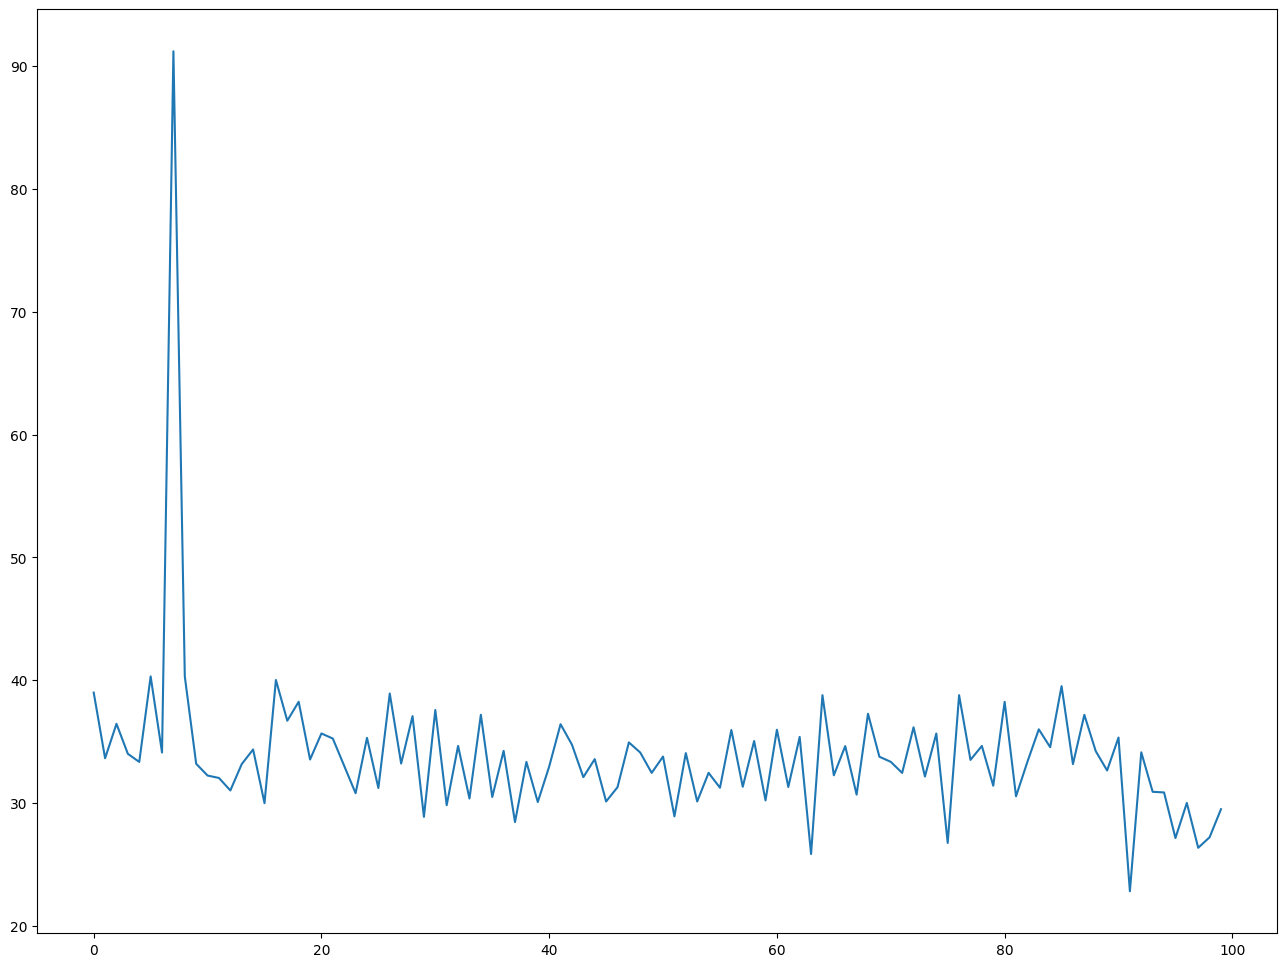

In [13]:
min_rmspe_calcu = min(rmspe_calcu_all_list)
min_rmspe_calcu_index = rmspe_calcu_all_list.index(min_rmspe_calcu)
print("{a}エポック目でRMSPE値の最小値：{b}".format(a=min_rmspe_calcu_index+1, b=min_rmspe_calcu))
# 全体のRMSPE値を図示
plt.figure(figsize=(16, 12))
plt.plot(range(len(rmspe_calcu_all_list)), rmspe_calcu_all_list)
plt.show()

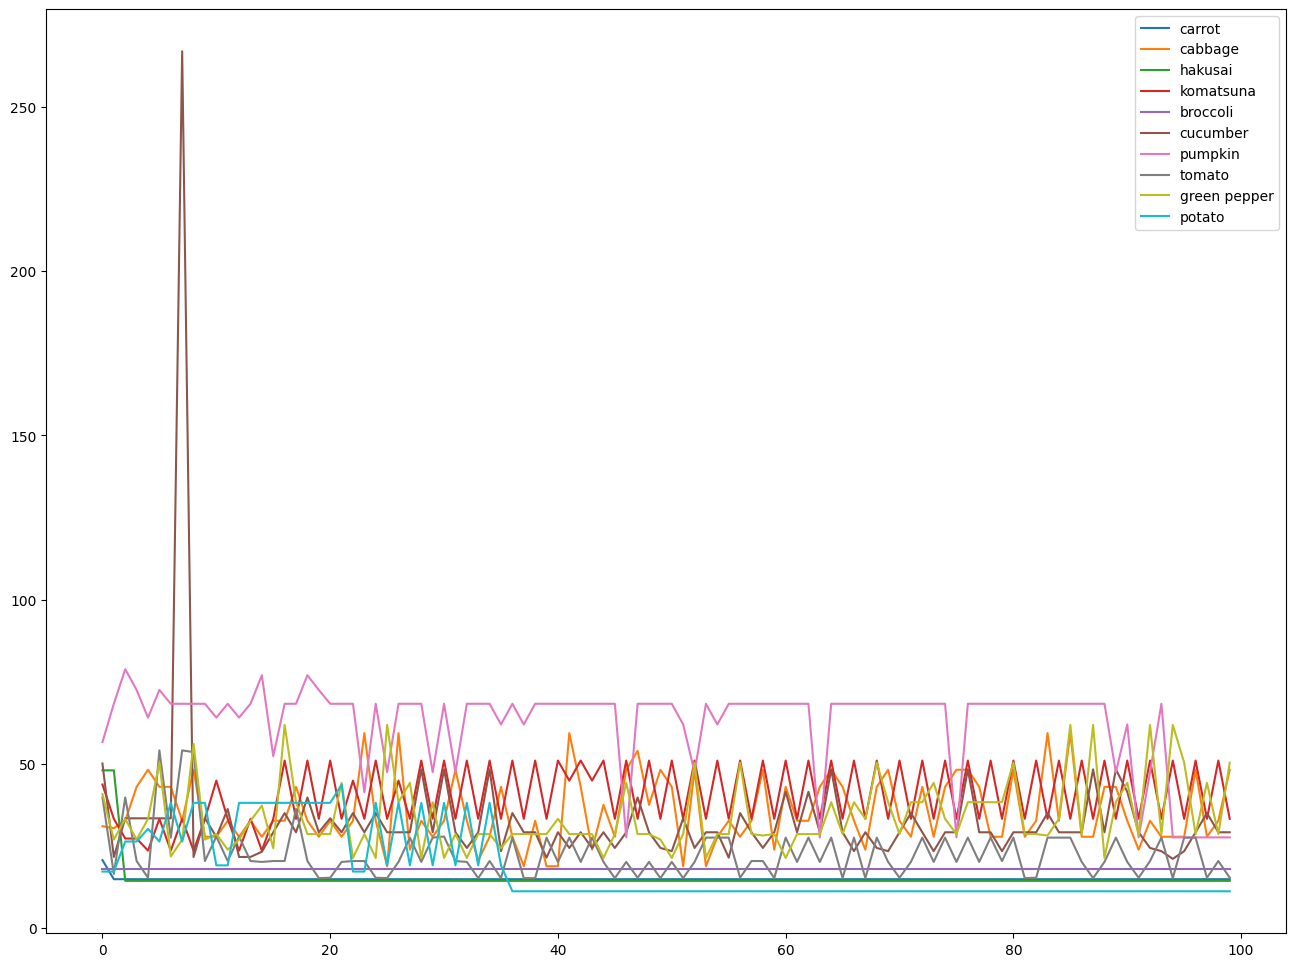

In [14]:
# kind毎のRMSPE値を図示
fig, ax = plt.subplots(figsize=(16, 12))
label_kind_dict = {"にんじん": "carrot",
                   "キャベツ": "cabbage",
                   "はくさい": "hakusai",
                   "こまつな": "komatsuna",
                   "ブロッコリー": "broccoli",
                   "きゅうり": "cucumber",
                   "かぼちゃ": "pumpkin",
                   "トマト": "tomato",
                   "ピーマン": "green pepper",
                   "じゃがいも": "potato"}
for name in label_kind_dict.keys():
    ax.plot(range(len(rmspe_calcu_kind_dict[name])), rmspe_calcu_kind_dict[name], label=label_kind_dict[name])
ax.legend(loc=0)
plt.show()

In [15]:
print(nn_model)

MyTransformer(
  (layer_1_encoder): Linear(in_features=2, out_features=512, bias=True)
  (layer_2_encoder): MyPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer_3_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer_1_decoder): Linear(in_features=

In [16]:
# 学習を行ったモデルの重み、バイアスのパラメータ数
params = 0
for p in nn_model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params)

10614971
